In [1]:
from IPython.core.display import display, HTML
display(HTML("""<style> .container {width:96% !important;}</style>"""))

from IPython.display import IFrame

In [2]:
import pandas as pd
import numpy as np
# from plotly.offline import init_notebook_mode, iplot
# import cufflinks as cf
# init_notebook_mode()
# cf.go_offline()
from __future__ import division

In [3]:
import xgboost as xgb

In [5]:
!ls -all additional_data
path = 'additional_data/'

total 152040
drwxr-xr-x  18 ehda-calvin  staff       576 Aug 31 17:49 .
drwxr-xr-x  15 ehda-calvin  staff       480 Oct 22 16:49 ..
-rw-r--r--   1 ehda-calvin  staff  24442347 Oct 22 16:48 nat03_04.csv
-rw-r--r--   1 ehda-calvin  staff  29970848 Oct 22 16:48 nat05_06.csv
-rw-r--r--   1 ehda-calvin  staff  21968872 Oct 22 16:48 nat07_08.csv
-rw-r--r--@  1 ehda-calvin  staff      1428 Aug 31 11:32 t0001-10.1080%2F10691898.2018.1434342.csv
-rw-r--r--@  1 ehda-calvin  staff       772 Aug 31 11:32 t0002-10.1080%2F10691898.2018.1434342.csv
-rw-r--r--@  1 ehda-calvin  staff       785 Aug 31 11:32 t0003-10.1080%2F10691898.2018.1434342.csv
-rw-r--r--@  1 ehda-calvin  staff       913 Aug 31 11:32 t0004-10.1080%2F10691898.2018.1434342.csv
-rw-r--r--@  1 ehda-calvin  staff       202 Aug 31 11:32 t0005-10.1080%2F10691898.2018.1434342.csv
-rw-r--r--@  1 ehda-calvin  staff       203 Aug 31 11:33 t0006-10.1080%2F10691898.2018.1434342.csv
-rw-r--r--@  1 ehda-calvin  staff       289 Aug 31 11:33 t0007-1

## Preprocessing

In [6]:
def default(x):
    if x == 'CHGOFF':
        return 1
    else:
        return 0

def to_float(x):
    x = x.replace('$', '')
    x = x.replace(',', '')
    x = float(x)
    return x

def SBA_ratio(SBA_Appv, GrAppv):
    if type(SBA_Appv) != float:
        SBA_Appv = to_float(SBA_Appv)
    if type(GrAppv) != float:
        GrAppv = to_float(GrAppv)
    return SBA_Appv/GrAppv

def franchise(x): 
    # FranchiseCode:    Franchise Code 00000 or 00001 = No Franchise
    if (x == 1) or (x == 0):
        return 0
    else:
        return 1
    
def extract_train_features(features, drop, categorical):
    print('-----> Extract train features <------')
    print 'dropping unwanted columns'
    features = features.drop(drop, axis=1)

    print 'transforming categorical variables'
    dict_categorical = {}
    for col in categorical:
        cat = pd.Categorical(features[col])
        new_col = col[:-1]+'INT'
        if col[-2] == '_':
            new_col = col[:-1]+'INT'
        else:
            new_col = col+'_INT'
        features.loc[:, new_col] = cat.codes
        dict_categorical[col] = dict([(k, v) for v, k in enumerate(cat.categories)])
    features = features.drop(categorical, axis=1)
    print 'done'
    return dict_categorical, features

def extract_test_features(test, drop, categorical, dict_categorical):
    print('-----> Extract test features <------')
    print 'dropping unwanted columns'
    test=test.drop(drop, axis=1)
    print 'transforming categorical variabless'
    for col in categorical:
        new_col = col[:-1]+'INT'
        if col[-2] == '_':
            new_col = col[:-1]+'INT'
        else:
            new_col = col+'_INT'
        test[new_col] = test[col].map(dict_categorical[col])
        test[new_col].fillna(-1, inplace=True)
    test=test.drop(categorical, axis=1)
    print 'done'
    return test

In [51]:
nat34 = pd.read_csv(path + 'nat03_04.csv')

In [52]:
print nat34.shape
nat34.head()

(126195, 32)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,default,SBA_ratio,NAICS_group,NAICS_default_rate,RealEstate
0,1005255000,Clark's Inc.,VISTA,CA,92084,CALIFORNIA BANK & TRUST,CA,442210,2002-11-06,2003,...,0.0,CHGOFF,40000.0,40000.0,20000.0,1,0.5,44,22.0,0
1,1005265003,James Byung Ho Park dba Parago,DOWNEY,CA,90242,CALIFORNIA BANK & TRUST,CA,422990,2002-11-06,2003,...,0.0,P I F,0.0,100000.0,50000.0,0,0.5,42,19.0,0
2,1005275006,Danny W. Temple and Beau M. Te,MONTE VISTA,CO,81144,CALIFORNIA BANK & TRUST,CA,561730,2002-11-06,2003,...,0.0,P I F,0.0,25000.0,12500.0,0,0.5,56,24.0,0
3,1005285009,"J & V Enterprises, LLC",COLORADO SPRINGS,CO,80906,CALIFORNIA BANK & TRUST,CA,722211,2002-12-10,2003,...,0.0,P I F,0.0,50000.0,25000.0,0,0.5,72,22.0,0
4,1005295001,Susana Chung dba Law Offices o,LOS ANGELES,CA,90010,CALIFORNIA BANK & TRUST,CA,541110,2002-12-10,2003,...,0.0,P I F,0.0,50000.0,25000.0,0,0.5,54,19.0,0


## Train, Test split

In [53]:
from sklearn import model_selection
train, test = model_selection.train_test_split(nat34, 
                                               test_size = 0.25, 
                                               random_state = 1868,
                                               stratify = nat34.default 
                                               )

print train.shape, test.shape
print train.default.sum()/train.shape[0], test.default.sum()/test.shape[0]


(94646, 32) (31549, 32)
0.164275299537 0.164284129449


In [54]:
# Preprocessing
train['Franchise'] = train['FranchiseCode'].apply(franchise)

/Users/ehda-calvin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [55]:
train.head().T

,94281,80222,120325,112496,111901
LoanNr_ChkDgt,7315064009,7097824002,7715604004,7577414007,7567144005
Name,COMPULANDZ,KOI DESIGN STUDIO INC,SALT PRODUCTIONS LTD,BRAMAAN ENTERPRISES LLC,J G M & ASSOCIATES INC
City,GREENVILLE,LOS ANGELES,NEW YORK,HAGUE,LEWES
State,RI,CA,NY,NY,DE
Zip,2828,90033,10014,12836,19958
Bank,CITIZENS BANK NATL ASSOC,CALIFORNIA BANK & TRUST,FIRST NIAGARA BANK NATL ASSOC,FIRST NIAGARA BANK NATL ASSOC,CITIZENS BANK NATL ASSOC
BankState,RI,CA,NY,NY,RI
NAICS,443120,561611,711410,722110,238320
ApprovalDate,2004-03-31,2004-01-15,2004-08-20,2004-07-01,2004-06-29
ApprovalFY,2004,2004,2004,2004,2004


In [56]:
# Preprocessing train set
features = train
target = train.default

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'NAICS_group'
              ]

dict_categorical, features = extract_train_features(features,
                                                    drop,
                                                    categorical)

print features.shape
print target.sum()

-----> Extract train features <------
dropping unwanted columns
transforming categorical variables
done
(94646, 19)
15548


In [57]:
features.head()

,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,GrAppv,SBA_Appv,SBA_ratio,NAICS_default_rate,RealEstate,Franchise,City_INT,State_INT,Zip_INT,Bank_INT,BankState_INT,RevLineCr_INT,LowDoc_INT,NAICS_group_INT
94281,1,1.0,0,1,1,5000.0,2500.0,0.5,22.0,0,0,3478,39,508,523,40,6,-1,7
80222,4,1.0,0,4,1,95000.0,47500.0,0.5,24.0,0,0,4954,4,14122,389,4,6,-1,14
120325,1,1.0,3,4,1,50000.0,25000.0,0.5,21.0,0,0,6084,34,1821,1027,35,6,-1,17
112496,72,1.0,0,72,2,60000.0,30000.0,0.5,22.0,0,0,3581,34,2388,1027,35,0,-1,18
111901,18,1.0,0,18,2,20000.0,10000.0,0.5,23.0,0,0,4788,8,3736,523,40,6,-1,4


In [59]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, 
                                                                    target, 
                                                                    test_size = 0.25, 
                                                                    random_state=3776,
                                                                    stratify=target 
                                                                   )


dtrain = xgb.DMatrix(X_train.values, label=y_train.values)
dtest = xgb.DMatrix(X_test.values, y_test.values)
num_rounds = 1100
# num_rounds = 2000

params = {'silent':1, 
          'eta':0.01, 
          'max_depth':10, 
          'subsample': 0.7, 
          'colsample_bytree': 0.6,
          'min_child_weight':1, 
          'objective':'binary:logistic', 
          'eval_metric':'auc', 
          'seed':2017, 
          'gamma':0.1,
          'nthread':-1}

watchlist = [(dtrain, 'train'),(dtest,'validation')]
bst=xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds = 50, verbose_eval = True);
num_rounds = bst.best_iteration
print num_rounds

[0]	train-auc:0.732877	validation-auc:0.71523
Multiple eval metrics have been passed: 'validation-auc' will be used for early stopping.

Will train until validation-auc hasn't improved in 50 rounds.
[1]	train-auc:0.759243	validation-auc:0.733147
[2]	train-auc:0.772884	validation-auc:0.744491
[3]	train-auc:0.781498	validation-auc:0.751105
[4]	train-auc:0.793886	validation-auc:0.760213
[5]	train-auc:0.797135	validation-auc:0.761531
[6]	train-auc:0.802345	validation-auc:0.764773
[7]	train-auc:0.806147	validation-auc:0.767335
[8]	train-auc:0.809283	validation-auc:0.768296
[9]	train-auc:0.812367	validation-auc:0.770848
[10]	train-auc:0.813707	validation-auc:0.771533
[11]	train-auc:0.813277	validation-auc:0.770712
[12]	train-auc:0.814522	validation-auc:0.769266
[13]	train-auc:0.813658	validation-auc:0.767557
[14]	train-auc:0.815667	validation-auc:0.769856
[15]	train-auc:0.816335	validation-auc:0.77191
[16]	train-auc:0.816449	validation-auc:0.773087
[17]	train-auc:0.816759	validation-auc:0.77

[168]	train-auc:0.856606	validation-auc:0.789335
[169]	train-auc:0.856765	validation-auc:0.789332
[170]	train-auc:0.856914	validation-auc:0.789467
[171]	train-auc:0.856991	validation-auc:0.789577
[172]	train-auc:0.857291	validation-auc:0.789725
[173]	train-auc:0.857402	validation-auc:0.789757
[174]	train-auc:0.857563	validation-auc:0.789889
[175]	train-auc:0.857732	validation-auc:0.789981
[176]	train-auc:0.857898	validation-auc:0.790042
[177]	train-auc:0.85804	validation-auc:0.79009
[178]	train-auc:0.858245	validation-auc:0.790098
[179]	train-auc:0.858492	validation-auc:0.790075
[180]	train-auc:0.858741	validation-auc:0.790129
[181]	train-auc:0.858878	validation-auc:0.790078
[182]	train-auc:0.858897	validation-auc:0.790105
[183]	train-auc:0.859026	validation-auc:0.790203
[184]	train-auc:0.859156	validation-auc:0.790194
[185]	train-auc:0.859183	validation-auc:0.790273
[186]	train-auc:0.859511	validation-auc:0.790291
[187]	train-auc:0.859657	validation-auc:0.790266
[188]	train-auc:0.8597

[336]	train-auc:0.879686	validation-auc:0.793484
[337]	train-auc:0.879749	validation-auc:0.793489
[338]	train-auc:0.879844	validation-auc:0.793516
[339]	train-auc:0.879937	validation-auc:0.793494
[340]	train-auc:0.880076	validation-auc:0.793509
[341]	train-auc:0.8802	validation-auc:0.793515
[342]	train-auc:0.880257	validation-auc:0.793529
[343]	train-auc:0.880421	validation-auc:0.793568
[344]	train-auc:0.880592	validation-auc:0.793577
[345]	train-auc:0.880632	validation-auc:0.793631
[346]	train-auc:0.880807	validation-auc:0.793628
[347]	train-auc:0.880985	validation-auc:0.793675
[348]	train-auc:0.8811	validation-auc:0.793695
[349]	train-auc:0.881168	validation-auc:0.793746
[350]	train-auc:0.881285	validation-auc:0.793801
[351]	train-auc:0.881517	validation-auc:0.793826
[352]	train-auc:0.881657	validation-auc:0.793889
[353]	train-auc:0.881762	validation-auc:0.793921
[354]	train-auc:0.881836	validation-auc:0.793962
[355]	train-auc:0.882042	validation-auc:0.794049
[356]	train-auc:0.882176

[504]	train-auc:0.895769	validation-auc:0.79495
[505]	train-auc:0.895831	validation-auc:0.794955
[506]	train-auc:0.895931	validation-auc:0.794951
[507]	train-auc:0.896016	validation-auc:0.794971
[508]	train-auc:0.896119	validation-auc:0.794964
[509]	train-auc:0.896186	validation-auc:0.794994
[510]	train-auc:0.896236	validation-auc:0.795041
[511]	train-auc:0.896277	validation-auc:0.795071
[512]	train-auc:0.896331	validation-auc:0.795095
[513]	train-auc:0.896375	validation-auc:0.795103
[514]	train-auc:0.896449	validation-auc:0.795109
[515]	train-auc:0.896518	validation-auc:0.795104
[516]	train-auc:0.896632	validation-auc:0.795126
[517]	train-auc:0.896677	validation-auc:0.795125
[518]	train-auc:0.896809	validation-auc:0.795125
[519]	train-auc:0.896849	validation-auc:0.795131
[520]	train-auc:0.896935	validation-auc:0.795131
[521]	train-auc:0.896987	validation-auc:0.795121
[522]	train-auc:0.89706	validation-auc:0.795132
[523]	train-auc:0.897244	validation-auc:0.795121
[524]	train-auc:0.8972

[672]	train-auc:0.9073	validation-auc:0.795397
[673]	train-auc:0.907329	validation-auc:0.795406
[674]	train-auc:0.907452	validation-auc:0.795426
[675]	train-auc:0.907504	validation-auc:0.795427
[676]	train-auc:0.907584	validation-auc:0.795423
[677]	train-auc:0.907662	validation-auc:0.795422
[678]	train-auc:0.907728	validation-auc:0.795393
[679]	train-auc:0.907783	validation-auc:0.795409
[680]	train-auc:0.907843	validation-auc:0.795406
[681]	train-auc:0.907965	validation-auc:0.795418
[682]	train-auc:0.908039	validation-auc:0.795414
[683]	train-auc:0.90815	validation-auc:0.795411
[684]	train-auc:0.908201	validation-auc:0.795433
[685]	train-auc:0.908265	validation-auc:0.795417
[686]	train-auc:0.908285	validation-auc:0.795416
[687]	train-auc:0.908321	validation-auc:0.795411
[688]	train-auc:0.908412	validation-auc:0.79541
[689]	train-auc:0.908431	validation-auc:0.795413
[690]	train-auc:0.908505	validation-auc:0.79541
[691]	train-auc:0.908549	validation-auc:0.795406
[692]	train-auc:0.908616	

In [60]:
# Use all the train data to train the model

X_train_matrix = features.values

#SKLEARN
clf_xgb = xgb.XGBClassifier(silent = params['silent'],
                            learning_rate = params['eta'],  
                            max_depth = params['max_depth'], 
                            subsample = params['subsample'], 
                            colsample_bytree = params['colsample_bytree'],
                            min_child_weight = params['min_child_weight'], 
                            objective = params['objective'], 
                            n_estimators = num_rounds,
                            seed = params['seed'],
                            nthread = params['nthread'],
                            gamma = params['gamma']
                                            )
clf_xgb.fit(X_train_matrix, 
            target, 
            eval_metric ='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.1, learning_rate=0.01,
       max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
       n_estimators=698, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2017, silent=1, subsample=0.7)

In [61]:
# Preprocessing test set
test_X = test.copy()
# Preprocessing
test_X['Franchise'] = test_X['FranchiseCode'].apply(franchise)
test_X['SBA_ratio'] = test_X.apply(lambda x: SBA_ratio(x['SBA_Appv'], x['GrAppv']), axis = 1)

# target = plu_n_test.Target

drop = ['LoanNr_ChkDgt', 'Name', 'ApprovalDate', 'ApprovalFY', 'ChgOffDate', 'DisbursementDate',
        'DisbursementGross', 'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 
        'default', 'FranchiseCode', 'Term', 'NAICS']

categorical = ['City', 'State', 'Zip', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'NAICS_group'
              ]

test_bas = extract_test_features(test_X,
                                 drop,
                                 categorical,
                                 dict_categorical)

-----> Extract test features <------
dropping unwanted columns
transforming categorical variabless
done


In [62]:
# Prediction

for col in features.columns:
    if col not in test_bas.columns:
        print 'MISSING COLUMN: ',col
        
test_bas= test_bas[features.columns]
X_test_matrix = test_bas.values
print X_train_matrix.shape, X_test_matrix.shape

y_pred_xgb = clf_xgb.predict_proba(X_test_matrix)
temp = pd.DataFrame(y_pred_xgb)


(94646, 19) (31549, 19)


In [63]:
test.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,default,SBA_ratio,NAICS_group,NAICS_default_rate,RealEstate
104760,7461474001,RELIANCE DATA INC,ARLINGTON,VA,22201,BANK OF AMERICA NATL ASSOC,NC,541512,2004-05-24,2004,...,0.0,P I F,0.0,100000.0,50000.0,0,0.50,54,19.0,0
24578,6117344004,GILSON'S AUTO BODY SHOP,ALBUQUERQUE,NM,87123,BANK OF AMERICA NATL ASSOC,NC,811111,2003-02-21,2003,...,0.0,P I F,0.0,50000.0,25000.0,0,0.50,81,20.0,0
124772,7824464009,ALL ABOUT KIDS INC,GRAND FORKS,ND,58203,ALERUS FINANCIAL NATL ASSOC,ND,624410,2004-09-20,2004,...,0.0,P I F,0.0,25000.0,12500.0,0,0.50,62,10.0,0
20754,6042984002,"HCD International, Inc.",LARGO,MD,20774,BANK OF AMERICA NATL ASSOC,NC,541618,2003-01-23,2003,...,0.0,P I F,0.0,100000.0,50000.0,0,0.50,54,19.0,0
28924,6184124008,"PICKERINGTON EYE CARE, INC.",PICKERINGTON,OH,43147,HEARTLAND BANK,OH,621320,2003-03-20,2003,...,0.0,P I F,0.0,80000.0,68000.0,0,0.85,62,10.0,0


In [64]:
kernix_check = test_X[['LoanNr_ChkDgt', 'Name', 'ApprovalFY', 'State', 'default']]
kernix_check['prob'] = y_pred_xgb[:,1]

/Users/ehda-calvin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
kernix_check.head()

,LoanNr_ChkDgt,Name,ApprovalFY,State,default,prob
104760,7461474001,RELIANCE DATA INC,2004,VA,0,0.092393
24578,6117344004,GILSON'S AUTO BODY SHOP,2003,NM,0,0.113209
124772,7824464009,ALL ABOUT KIDS INC,2004,ND,0,0.099592
20754,6042984002,"HCD International, Inc.",2003,MD,0,0.310205
28924,6184124008,"PICKERINGTON EYE CARE, INC.",2003,OH,0,0.122220


In [66]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn
import matplotlib.pyplot as plt
seaborn.set_style('darkgrid')

def __to_percent1(y, position):
    y = y * 100.0
    return "{:.1f}%".format(y)

def plot_roc(target, predicted_proba, title, save_png=''):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        from sklearn.metrics import roc_curve, roc_auc_score

        fpr, tpr, _ = roc_curve(target, predicted_proba)
        auc_plot = roc_auc_score(target, predicted_proba)        
        plt.figure()
        plt.plot(fpr, tpr, '-', alpha=.8, color='red', lw=1.5, label= title + ' (auc = %0.3f)' % auc_plot)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Chance')

        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.xlabel('Non default cases', fontsize=15)
        plt.ylabel('Default cases', fontsize=15)

        plt.title("\nROC curve - {}\n".format(title), fontsize=18)
        plt.legend(loc="lower right", fontsize=15)
        
        if save_png != '':
                plt.savefig(save_png, format="png")
        else:
                plt.show()

def plot_grade_roc(target, grade, predicted_proba, title, save_png=''):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as mtick
        from sklearn.metrics import roc_curve, roc_auc_score

        fpr, tpr, _ = roc_curve(target, predicted_proba)
        fpr_plot, tpr_plot, _ = roc_curve(target, wastage_grade)
        raw_auc_plot = roc_auc_score(target, predicted_proba)
        new_grade_auc_plot = roc_auc_score(target, wastage_grade)

        plt.figure()
        plt.plot(fpr, tpr, '-', color='grey', alpha=.3, label="Raw PD (auc = %0.3f)" % raw_auc_plot)
        plt.plot(fpr_plot, tpr_plot, 'o-', color='red', alpha=.8, lw=1.5, label= title + ' (auc = %0.3f)' % new_grade_auc_plot)
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', label='Chance')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(__to_percent1))
        plt.xlabel('Non wasted policies', fontsize=15)
        plt.ylabel('Wasted policies', fontsize=15)

        plt.title("\nROC curve - {}\n".format(title), fontsize=18)
        plt.legend(loc="lower right", fontsize=15)

        bbox_props = dict(boxstyle="circle,pad=0.3", fc="white", ec="#2769a6", lw=1)
        bbox_props2 = dict(boxstyle="circle,pad=0.3", fc="white", ec="red", lw=1)
        bbox_props3 = dict(boxstyle="circle,pad=0.3", fc="white", ec="blue", lw=1)
        
        for i in range(0,6):
                if i >= 1 and i <= 6:
                        try:
                                plt.text(fpr_plot[i] - .01, tpr_plot[i] + .05, "%s" % (6 - i), color="red", ha="center", va="center", size=15, bbox=bbox_props2)
                        except:
                                pass
        
        if save_png != '':
                plt.savefig(save_png, format="png")
        plt.show()

Populating the interactive namespace from numpy and matplotlib


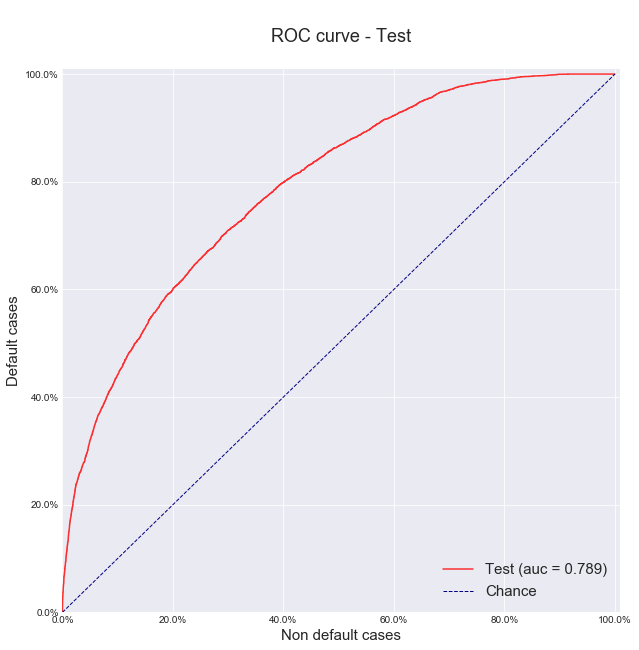

In [67]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 10)
plot_roc(kernix_check.default, kernix_check.prob, 'Test')

In [68]:
# Feature Importance

#BOOSTER
dtrain_ex=xgb.DMatrix(features.values,
                      label=target.values,
                      feature_names=features.columns)

bst_ex=xgb.train(params,
                 dtrain_ex,
                 num_boost_round=bst.best_iteration,
                 verbose_eval=False
                )
bst_ex.feature_names[:10]

['NoEmp',
 'NewExist',
 'CreateJob',
 'RetainedJob',
 'UrbanRural',
 'GrAppv',
 'SBA_Appv',
 'SBA_ratio',
 'NAICS_default_rate',
 'RealEstate']

In [69]:
def print_features_importance(bst):
    x = bst.get_fscore()
    sorted_x = sorted(x.items(), key=lambda x: x[1], reverse=True)
    keys_max = [item[0] for item in sorted_x[:30]]
    feat_max = {key: x[key] for key in keys_max}
    features_importance = pd.DataFrame([feat_max]).T
    features_importance = features_importance.rename(columns = {0: 'Score'})
    features_importance = features_importance.sort_values('Score', ascending=False)
    return features_importance

In [70]:
feat_max = print_features_importance(bst_ex)
feat_max.rename(columns = {'Score': 'Accumlated score'}).head(15)

,Accumlated score
Zip_INT,33450
City_INT,25470
GrAppv,16792
Bank_INT,16156
SBA_Appv,16063
NoEmp,14266
BankState_INT,11426
RetainedJob,11245
State_INT,11024
NAICS_group_INT,9782


In [25]:
# train.groupby(['Zip', 'default']).count().max(1)
# train[train.default == 1].Zip.astype(str).str[:2].value_counts()
# train[train.default == 1].Zip.value_counts()
# train[train.default == 1].City.value_counts()